Import library yang diperlukan

In [ ]:
!pip install opendatasets

In [ ]:
# link = "https://https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection"
link = "https://www.kaggle.com/datasets/preetviradiya/brian-tumor-dataset"

import opendatasets as od
od.download(link)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: a
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/preetviradiya/brian-tumor-dataset


100%|██████████| 107M/107M [00:02<00:00, 43.6MB/s]


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage import feature
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

DATASET_PATH = "./brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set/"

In [ ]:
metadata_df = pd.read_csv('./brian-tumor-dataset/metadata.csv')
metadata_df[metadata_df['mode'] == 'L']

,Unnamed: 0,image,class,format,mode,shape
1,1,Cancer (1).png,tumor,PNG,L,"(300, 240)"
36,36,Cancer (1028).jpg,tumor,JPEG,L,"(336, 300)"
239,239,Cancer (1209).jpg,tumor,JPEG,L,"(336, 300)"
269,269,Cancer (1236).jpg,tumor,JPEG,L,"(1024, 1024)"
293,293,Cancer (1258).jpg,tumor,JPEG,L,"(1427, 1275)"
...,...,...,...,...,...,...
4561,4561,Not Cancer (964).jpg,normal,JPEG,L,"(225, 225)"
4566,4566,Not Cancer (969).jpg,normal,JPEG,L,"(1024, 1024)"
4571,4571,Not Cancer (973).jpg,normal,JPEG,L,"(275, 220)"
4577,4577,Not Cancer (979).jpg,normal,JPEG,L,"(301, 275)"


Load dataset and preprocessing

Untuk preprocessing sendiri kita menggunakan beberapa pendekatan seperti
- convert to gray scale untuk mengurangi dimensi yang awalnya 3 menjadi 1 (karena warna)
- resize supaya ukuran gambar konsisten saat dimodelkan
- blur untuk mengurangi noise

In [ ]:
labels = os.listdir(DATASET_PATH)

images = []
labels_list = []

for idx,folder in enumerate(labels):
    folder_path = os.path.join(DATASET_PATH, folder)
    img_names = os.listdir(folder_path)

    for img_name in img_names:
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (224, 224))
        img = cv2.medianBlur(img, ksize=7)

        # eq = cv2.equalizeHist(img)
        # thresh = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

        images.append(img)
        labels_list.append(idx)

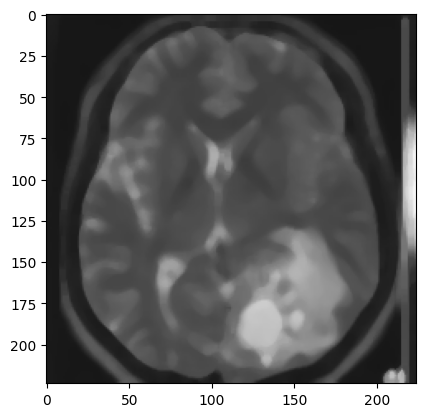

In [ ]:
plt.imshow(cv2.cvtColor(images[4], cv2.COLOR_GRAY2RGB))
plt.show()

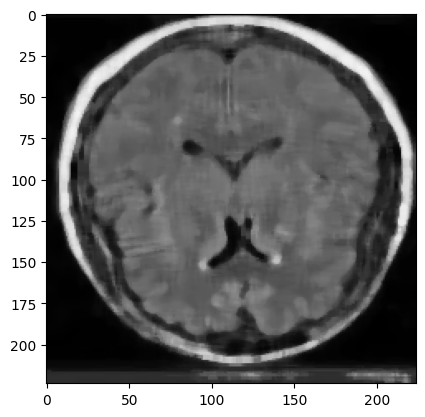

In [ ]:
plt.imshow(cv2.cvtColor(images[-1], cv2.COLOR_GRAY2RGB))
plt.show()

Feature Extraction:
- LBP (local binary pattern)
- GLCM (gray level covariance matrix)

Reason:
Karena fitur utama dari task deteksi tumor melalui citra adalah tekstur tumornya sendiri. mungkin ada juga beberapa fitur lain salah satunya seperti edge akan tetapi masih kurang karena ada kemungkinan tumornya berlokasi di tengah-tengah otaknya. selain itu juga pada dasarnya ketika seseorang mengalami tumor, pastinya akan ada tekstur tidak normal pada otaknya si penderita sehingga penggunaan tekstur sebagai fitur dinilai lebih baik untuk mendeskripsikan tumor pada otak.

Untuk metode ekstraksi fiturnya kita menggunakan LBP dan GLCM. Alasannya adalah karena GLCM mampu untuk mendeteksi karakteristik tumor yang ada pada otak melalui contrast, homogeneity, energi, dan korelasi. selain itu, penggunaan GLCM juga berguna ketika kita membutuhkan global feature extraction. sedangkan untuk LBP disini digunakan untuk local feature extraction yang membutuhkan informasi tekstur yang lebih detail

In [ ]:
lbp_features = []
contrasts = []
homogenity = []
energy = []
correlation = []
entropy = []
dissimilarity = []
asm = []

In [ ]:

num_point = 24
radius = 6
def extract_feature(image):
    lbp = feature.local_binary_pattern(image, num_point,radius,
                                       method="uniform")
    glcm = feature.graycomatrix(image, [1,2,3,4,5,6,7,8],
        [0, np.pi/4, np.pi/2, np.pi*3/4],
        levels=256, symmetric=True, normed=True)
    (hist, _) = np.histogram(lbp.ravel(),bins=np.arange(0, num_point + 3),
        range=(0, radius + 2))
    hist = hist.astype("float")
    hist /= hist.sum()
    return hist, glcm

for image in images:
  hist, glcm = extract_feature(image)
  contrasts.append(np.reshape(feature.graycoprops(glcm, 'contrast'), [32]))
  homogenity.append(np.reshape(feature.graycoprops(glcm, 'homogeneity'), [32]))
  correlation.append(np.reshape(feature.graycoprops(glcm, 'correlation'),
   [32]))
  dissimilarity.append(np.reshape(feature.graycoprops(glcm, 'dissimilarity'),
   [32]))
  entropy.append(np.reshape(feature.graycoprops(glcm, 'entropy'), [32]))
  energy.append(np.reshape(feature.graycoprops(glcm, 'energy'), [32]))
  asm.append(np.reshape(feature.graycoprops(glcm, 'ASM'), [32]))
  lbp_features.append(hist)



Pembuatan dataframe dari glcm dan lbp

In [ ]:
lbp_df = pd.DataFrame(lbp_features)

energy_df = pd.DataFrame(energy)
contrasts_df = pd.DataFrame(contrasts)
homogenity_df = pd.DataFrame(homogenity)
correlation_df = pd.DataFrame(correlation)
# mean_df = pd.DataFrame(mean)
# std_df = pd.DataFrame(std)
# variance_df = pd.DataFrame(variance)
entropy_df = pd.DataFrame(entropy)
asm_df = pd.DataFrame(asm)
dissimilarity_df = pd.DataFrame(dissimilarity)
df = pd.concat([lbp_df, energy_df, contrasts_df, homogenity_df, correlation_df, entropy_df, dissimilarity_df, asm_df],axis=1)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.026905,0.011141,0.019033,0.021883,0.015127,0.015685,0.016821,0.019511,0.021325,0.028679,...,0.001231,0.001297,0.001554,0.001035,0.001056,0.001000,0.001395,0.000822,0.000951,0.000795
1,0.019711,0.004963,0.010244,0.015007,0.015027,0.014569,0.013831,0.015685,0.016940,0.019910,...,0.051336,0.040990,0.034895,0.037486,0.050292,0.037173,0.032055,0.033988,0.049393,0.033721
2,0.031669,0.015864,0.019691,0.016542,0.009566,0.008929,0.008151,0.009367,0.010503,0.016681,...,0.040306,0.034403,0.029223,0.030261,0.038656,0.030793,0.026621,0.026898,0.037103,0.027470
3,0.021644,0.010862,0.013951,0.017478,0.014927,0.016422,0.017738,0.018913,0.019810,0.023537,...,0.039191,0.036309,0.034047,0.033031,0.037184,0.032667,0.031723,0.029703,0.035262,0.029246
4,0.034718,0.012855,0.019551,0.026547,0.020548,0.019671,0.018415,0.017857,0.020269,0.025191,...,0.002771,0.002208,0.001666,0.001757,0.002553,0.001930,0.001472,0.001518,0.002383,0.001708


Visualisasi intensitas dari LBP

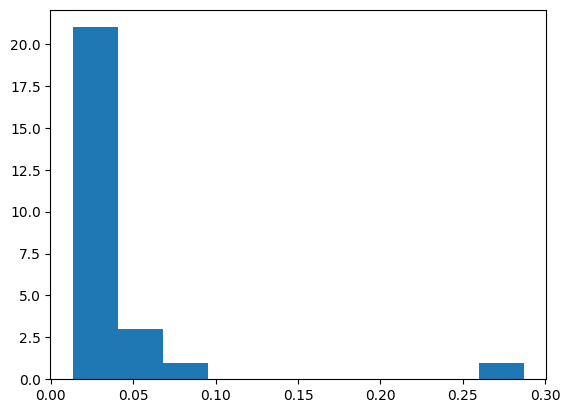

In [ ]:

plt.hist(lbp_features[1])
plt.show()

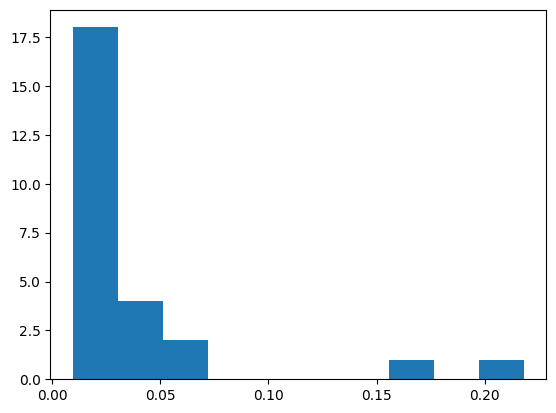

In [ ]:
plt.hist(lbp_features[-2])
plt.show()

Normalisasi menggunakan standard scaler

In [ ]:
scaler = StandardScaler()
image_features = scaler.fit_transform(df)
image_features.shape

In [ ]:
from sklearn.decomposition import PCA
x_train, x_test, y_train, y_test = train_test_split(
    image_features,
    labels_list,
    test_size=0.3,
    random_state=42
    )

pca = PCA(n_components=80)

x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)


In [ ]:
import time
classifiers = {
        'Logistic Regression': LogisticRegression( max_iter=1000),
        # 'Logistic Regression': LogisticRegression(C=4.281332398719396, max_iter=1000, penalty='l1',solver='saga'),
        'Support Vector Machine (Linear)': SVC(kernel='linear', probability=True),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    }
best = 'Logistic Regression'
best_val = 0

for clf in classifiers:
    start_train = time.time()
    classifiers[clf].fit(x_train, y_train)
    end_train = time.time()
    y_pred = classifiers[clf].predict(x_test)
    print(f"Training Time: {end_train - start_train:.4f} seconds")
    print(clf)
    print(classification_report(y_test, y_pred))
    acc = accuracy_score(y_test, y_pred)
    print(acc)

    if acc > best_val:
        best_val = acc
        best = clf


Training Time: 0.4982 seconds
Logistic Regression
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       779
           1       0.82      0.81      0.82       601

    accuracy                           0.84      1380
   macro avg       0.84      0.84      0.84      1380
weighted avg       0.84      0.84      0.84      1380

0.8405797101449275
Training Time: 9.7325 seconds
Support Vector Machine (Linear)
              precision    recall  f1-score   support

           0       0.87      0.85      0.86       779
           1       0.81      0.84      0.82       601

    accuracy                           0.84      1380
   macro avg       0.84      0.84      0.84      1380
weighted avg       0.84      0.84      0.84      1380

0.841304347826087
Training Time: 0.4569 seconds
Decision Tree
              precision    recall  f1-score   support

           0       0.92      0.89      0.90       779
           1       0.86      0.89      0.88 